# **Predicting Austin Housting Prices Colab Notebook**
### Richard Lee, Tiffany Lee, Won Shil Park, Samuel Tesfai

# Import Libraries and Load Datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# directory path
%cd /content/drive/MyDrive/'IEOR 142 Final Project Materials'

/content/drive/MyDrive/IEOR 142 Final Project Materials


In [ ]:
df = pd.read_csv("cleandata.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6,18,19,20,21,22,23,24,25,34,35,36,37,38,47,48,49,50,51,52,55,56,57,58,65,92,94,95,96,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,127,128,129,130,131,137,138,139,140,142,143,151,152,153,154,161,162,163,164,165,166,174,175,177,182,183,184,185,186,187,188,189,191,198,207,211,212,213,218,219,221,222,223,224,225,226,227,228,229,230,234,314,316,318,320,322,324,326,328,330,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,357,358,359,360,361,362,363,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,387,388,389,390,391,392,393,395,397,398,399,400,401,403,405,406,407,409,411,413,414,415,417,418,419,421,422,423,425,426,427,429,431,433,434,435,436,437,439,441,443,444,445,447,449,451,453,455,457,458,459,461,463,465,467,469,471,473,475,477,479,480,481,483,485,486,563,564,565,566,572,577,578,579,580,592,5

## Utility Functions

#### Metric Definitions Helper functions

In [ ]:
def OS_R_squared(predictions, y_test,y_train):
    SSE = np.sum((y_test-predictions)**2)
    SST = np.sum((y_test-np.mean(y_train))**2)
    r2 = 1-SSE/SST
    return r2

def mean_squared_error(predictions, y_test,y_train):
    MSE = np.mean((y_test-predictions)**2)
    return MSE

def root_mean_squared_error(predictions, y_test,y_train):
    RMSE = np.sqrt(mean_squared_error(predictions, y_test,y_train))
    return RMSE

def mean_absolute_error(predictions, y_test,y_train):
    MAE = np.mean(np.abs(y_test-predictions))
    return MAE

def OSR2(model, X_test, y_test, y_train):   
    y_pred = model.predict(X_test)
    return OS_R_squared(y_pred, y_test,y_train)

#### Report Metrics Helper Functions 

In [ ]:
def report_metrics(X_test,y_test,y_train,y_pred):
    osr2 = OS_R_squared(y_pred,y_test,y_train)
    rmse = root_mean_squared_error(y_pred,y_test,y_train)
    mae = mean_absolute_error(y_pred,y_test,y_train)
    print("OSR2: %s" % osr2)
    print("RMSE: %s" % rmse)
    print("MAE:  %s" % mae)
    return osr2, rmse, mae

In [ ]:
def report_metrics_smf(model,df_test,df_train):
    import patsy
    f = model.model.formula
    y_train,X_train = patsy.dmatrices(f, df_train, return_type='dataframe')
    y_test,X_test = patsy.dmatrices(f, df_test, return_type='dataframe')
    y_pred = model.predict(df_test)
    return report_metrics(X_test.to_numpy(),y_test.iloc[:,0].T,
                          y_train.iloc[:,0].T,y_pred)

In [ ]:
def report_metrics_sklearn(model,X_test,y_test,y_train):
    y_pred = model.predict(X_test)
    return report_metrics(X_test,y_test,y_train,y_pred)

In [ ]:
# accommodates target if it is in log scale
def report_metrics_sklearn_log(model,X_test,y_test,y_train):
    y_pred = model.predict(X_test)
    y_pred_normalize = np.array([np.exp(i) for i in y_pred])
    y_train_normalize = y_train.apply(np.exp)
    y_test_normalize = y_test.apply(np.exp)
    return report_metrics(X_test,y_test_normalize,y_train_normalize,
                          y_pred_normalize)

#### Report Metrics Utility Functions (used for performance)

In [ ]:
performance_table = pd.DataFrame(columns = ['Algorithm','OSR^2','RMSE','MAE'])

In [ ]:
def do_report_metrics_smf(algo, model, df_test, df_train):
    osr2, rmse, mae = report_metrics_smf(model, df_test, df_train)
    global performance_table
    performance_table = (performance_table
      .append(pd.DataFrame({
      'Algorithm': [algo],
      'OSR^2': [osr2],
      'RMSE': [rmse],
      'MAE': [mae],
      }), ignore_index=True)
    )

In [ ]:
def do_report_metrics_sklearn(algo, model, X_test, y_test, y_train, 
                              is_log_target = False):
    if is_log_target:
        osr2, rmse, mae = report_metrics_sklearn_log(model, X_test, y_test, 
                                                     y_train)
    else: 
        osr2, rmse, mae = report_metrics_sklearn(model, X_test, y_test, y_train)
    global performance_table
    performance_table = (performance_table
      .append(pd.DataFrame({
      'Algorithm': [algo],
      'OSR^2': [osr2],
      'RMSE': [rmse],
      'MAE': [mae],
      }), ignore_index=True)
)

# Feature Selection and Data Preprocessing

## Drop columns with 80%+ NaN values

In [ ]:
# we only keep the columns with 80%+ non NAs values
df1=df.dropna(axis=1,thresh=len(df)*.80)
df1.loc[637,'yearBuilt']=2019

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
# feature selection
for e in range(df1.shape[1]):
    print(e,df1.columns[e])

0 Unnamed: 0
1 Unnamed: 0.1
2 address_city
3 address_state
4 address_streetAddress
5 address_zipcode
6 bathrooms
7 bedrooms
8 description
9 homeStatus
10 latitude
11 livingArea
12 longitude
13 propertyTaxRate
14 resoFactsStats_appliances_0
15 resoFactsStats_appliances_1
16 resoFactsStats_atAGlanceFacts_0_factLabel
17 resoFactsStats_atAGlanceFacts_0_factValue
18 resoFactsStats_atAGlanceFacts_1_factLabel
19 resoFactsStats_atAGlanceFacts_1_factValue
20 resoFactsStats_atAGlanceFacts_2_factLabel
21 resoFactsStats_atAGlanceFacts_2_factValue
22 resoFactsStats_atAGlanceFacts_3_factLabel
23 resoFactsStats_atAGlanceFacts_3_factValue
24 resoFactsStats_atAGlanceFacts_4_factLabel
25 resoFactsStats_atAGlanceFacts_4_factValue
26 resoFactsStats_atAGlanceFacts_5_factLabel
27 resoFactsStats_atAGlanceFacts_5_factValue
28 resoFactsStats_bathrooms
29 resoFactsStats_bathroomsFull
30 resoFactsStats_bathroomsHalf
31 resoFactsStats_bathroomsOneQuarter
32 resoFactsStats_bathroomsThreeQuarter
33 resoFactsStats_b

## Drop columns by index

In [ ]:
columns_to_drop = [0,1,2,3,4,5,6,7,8,9,14,15,16,18,19,20,21,22,23,24,25,26,27,
                   28,31,32,34,37,38,43,45,48,50,51,54,55,56,57,58,59,61,62]
                   +list(range(63,81))
columns_to_drop += [81,82,83,84,88]
school_info=[89,90,91,92,93,94,96,97,98,99,100,101,102,103,104,105,107,108,109,
             110,111,112,113,114,115,116,117,118,119,120,121]
columns_to_drop+=school_info
columns_to_drop+=[122,124,126,127,130,135,136,137]

## Drop redundant rows

In [ ]:
#drops columns and removes nan rows
df2=df1.iloc[:,[i for i in range(138) if i not in columns_to_drop]]
df2=df2.rename(columns={'resoFactsStats_atAGlanceFacts_0_factValue':'Type',
                        'resoFactsStats_bathroomsFull':'bathroomsFull',
                        'resoFactsStats_bathroomsHalf':'bathroomsHalf',
                        'resoFactsStats_bedrooms':'bedrooms',
                        'resoFactsStats_cooling_0':'Cooling',
                        'resoFactsStats_foundationDetails_0':"Foundation",
                        'resoFactsStats_flooring_0':'flooring',
                        'resoFactsStats_cityRegion':'CityRegion'})
df2=df2.dropna()

## Convert lot size areas from acres to sqft

In [ ]:
# converts all lot size areas to acres
def area_converter(area):
    if area[area.find(" ")+1:]=="Acres":
        return float(area[:area.find(" ")].replace(',',''))
    else:
        return float(area[:area.find(" ")].replace(',',''))/43560

#df2['lotSize']=df2['lotSize'].apply(area_converter)

In [ ]:
df2['lotSize'].head()

0    0.36 Acres
1    0.66 Acres
3    0.49 Acres
4    0.48 Acres
5    7,797 sqft
Name: lotSize, dtype: object

In [ ]:
# converts all lot size areas to acres
def area_converter_sqft(area):
    if area[area.find(" ")+1:]=="sqft":
        return float(area[:area.find(" ")].replace(',',''))
    else:
        return float(area[:area.find(" ")].replace(',',''))*43560
df2['lotSize']=df2['lotSize'].apply(area_converter_sqft)

## One-Hot Encoding

In [ ]:
# Handling Categoricals with one hot encoding
# Note: you'll need to use dummy encoding for linear regression, you can achieve
# this by passing in drop_first=True into get_dummies
df3 = pd.get_dummies(df2)
df3.columns = df3.columns.str.replace(r'\s+|/|\(|\)', '',regex=True)
# columns.str.replace() is a much more efficient way to process column names
# with punctuation issues than my earlier code using list comprehensions

## Train Test Split

In [ ]:
#Train test split - statsmodels
df3_train, df3_test = train_test_split(df3, test_size=0.3, random_state=42)

In [ ]:
target=df3['latest_price']
features=df3.drop(columns='latest_price')

# remaining columns
features.columns

Index(['latitude', 'livingArea', 'longitude', 'propertyTaxRate',
       'bathroomsFull', 'bathroomsHalf', 'bedrooms', 'furnished',
       'garageSpaces', 'hasAttachedGarage', 'hasCarport', 'hasCooling',
       'hasHeating', 'hasSpa', 'hasView', 'lotSize', 'stories',
       'taxAnnualAmount', 'taxAssessedValue', 'schools_0_rating',
       'schools_1_rating', 'yearBuilt', 'latest_salemonth', 'latest_saleyear',
       'numOfAccessibilityFeatures', 'numOfAppliances', 'numPhotos',
       'numPriceChanges', 'Type_Apartment', 'Type_Condo',
       'Type_MobileManufactured', 'Type_MultiFamily', 'Type_SingleFamily',
       'Type_SingleFamily', 'Type_Townhouse', 'Type_Unknown',
       'Type_VacantLand', 'CityRegion_Austin', 'CityRegion_DelValle',
       'CityRegion_Driftwood', 'CityRegion_DrippingSprings',
       'CityRegion_Manchaca', 'CityRegion_Manor', 'CityRegion_Pflugerville',
       'CityRegion_WestLakeHills', 'Cooling_1Unit', 'Cooling_2Units',
       'Cooling_Central', 'Cooling_CentralAir'

In [ ]:
#Train test split - scikit_learn
X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [ ]:
# np.log() applied to target
y_log_train = np.log(y_train)
y_log_test = np.log(y_test)

# Models

## Linear Regression Model

In [ ]:
target_name = 'latest_price'
feature_names = features.columns
frmla = target_name + ' ~ ' + ' + '.join(feature_names)
frmla

'latest_price ~ latitude + livingArea + longitude + propertyTaxRate + bathroomsFull + bathroomsHalf + bedrooms + furnished + garageSpaces + hasAttachedGarage + hasCarport + hasCooling + hasHeating + hasSpa + hasView + lotSize + stories + taxAnnualAmount + taxAssessedValue + schools_0_rating + schools_1_rating + yearBuilt + latest_salemonth + latest_saleyear + numOfAccessibilityFeatures + numOfAppliances + numPhotos + numPriceChanges + Type_Apartment + Type_Condo + Type_MobileManufactured + Type_MultiFamily + Type_SingleFamily + Type_SingleFamily + Type_Townhouse + Type_Unknown + Type_VacantLand + CityRegion_Austin + CityRegion_DelValle + CityRegion_Driftwood + CityRegion_DrippingSprings + CityRegion_Manchaca + CityRegion_Manor + CityRegion_Pflugerville + CityRegion_WestLakeHills + Cooling_1Unit + Cooling_2Units + Cooling_Central + Cooling_CentralAir + Cooling_Electric + Cooling_None + Cooling_Other + Cooling_Refrigerator + Cooling_Solar + Cooling_Wall + Cooling_WallWindowUnits + floori

In [ ]:
 # Linear Regression Model
import statsmodels.formula.api as smf

ols = smf.ols(formula=frmla, data=df3_train)
model1 =ols.fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:           latest_price   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     851.1
Date:                Sat, 18 Dec 2021   Prob (F-statistic):               0.00
Time:                        00:19:25   Log-Likelihood:            -1.1740e+05
No. Observations:                8776   AIC:                         2.349e+05
Df Residuals:                    8708   BIC:                         2.354e+05
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [ ]:
# compute out-of-sample R-squared using the test set
def OSR2(model, df_train, df_test, dependent_var):   
    y_test = df_test[dependent_var]
    y_pred = model.predict(df_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(df_train[dependent_var]))**2)    
    return 1 - SSE/SST

In [ ]:
OSR2(model1, df3_train, df3_test, 'latest_price')

0.768604630914903

### Model Performance

In [ ]:
# Only run this once after completing run for each model, because it will add a 
# row to the performance_table after every run
do_report_metrics_smf('Linear Regression (OLS)', model1, df3_test, df3_train)

OSR2: 0.768604630914903
RMSE: 227705.06069607005
MAE:  77046.61898400582


## Linear Regression after applying Variable Inflation Factors (VIF)

In [ ]:
# calculate Variance Inflation Factor for each explanatory variable
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# The dataframe passed to VIF must include the intercept term. We add it the 
# same way we did before.
def VIF(df, columns):
    values = sm.add_constant(df[columns]).values
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    return pd.Series(vif[1:], index=columns)

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_df3_train = df3_train.select_dtypes(include=numerics)
VIF(df3_train, num_df3_train.columns)

latitude                       2.254791
livingArea                     3.896345
longitude                      2.550324
propertyTaxRate                1.473517
bathroomsFull                  1.730715
bathroomsHalf                  1.611978
bedrooms                       1.915593
garageSpaces                   1.228807
lotSize                        1.377702
stories                        1.812886
taxAnnualAmount               12.304308
taxAssessedValue              19.233612
schools_0_rating               1.659811
schools_1_rating               2.657527
yearBuilt                      1.434311
latest_price                   7.371866
latest_salemonth               1.046252
latest_saleyear                1.286403
numOfAccessibilityFeatures     1.012012
numOfAppliances                1.037103
numPhotos                      1.279015
numPriceChanges                1.062766
dtype: float64

In [ ]:
# drop taxAnnualAmount because of high VIF, although taxAssessedValue 
target_name = 'latest_price'
feature_names1 = features.drop(['taxAnnualAmount'], axis = 1).columns
frmla = target_name + ' ~ ' + ' + '.join(feature_names1)

ols = smf.ols(formula=frmla, data=df3_train)
model2 =ols.fit()
print(model2.summary())

col = num_df3_train.drop(['taxAnnualAmount'], axis = 1).columns
VIF(df3_train, col)

                            OLS Regression Results                            
Dep. Variable:           latest_price   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     859.7
Date:                Sat, 18 Dec 2021   Prob (F-statistic):               0.00
Time:                        00:19:27   Log-Likelihood:            -1.1742e+05
No. Observations:                8776   AIC:                         2.350e+05
Df Residuals:                    8709   BIC:                         2.355e+05
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

latitude                      2.236849
livingArea                    3.879482
longitude                     2.540883
propertyTaxRate               1.471695
bathroomsFull                 1.727519
bathroomsHalf                 1.611945
bedrooms                      1.915326
garageSpaces                  1.227054
lotSize                       1.377136
stories                       1.812880
taxAssessedValue              8.120016
schools_0_rating              1.659325
schools_1_rating              2.652496
yearBuilt                     1.412861
latest_price                  7.351698
latest_salemonth              1.046002
latest_saleyear               1.270062
numOfAccessibilityFeatures    1.011933
numOfAppliances               1.036809
numPhotos                     1.278823
numPriceChanges               1.050204
dtype: float64

### Model Performance

In [ ]:
OSR2(model2, df3_train, df3_test, 'latest_price')

0.7756349613749214

In [ ]:
# Only run this once after completing run for each model, because it will add a 
# row to the performance_table after every run
do_report_metrics_smf('Linear Regression (OLS) after VIF', model2, df3_test, 
                      df3_train)

OSR2: 0.7756349613749214
RMSE: 224219.27475569453
MAE:  76752.65477382072


## CART - Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

dtr = DecisionTreeRegressor(min_samples_split=10, 
                            ccp_alpha=0.02,
                            random_state = 88)
dtr = dtr.fit(X_train, y_train)

### Model Performance

In [ ]:
# Only run this once after completing run for each model, because it will add a 
# row to the performance_table after every run
do_report_metrics_sklearn('Decision Tree Regressor', dtr, X_test, y_test, 
                          y_train)

OSR2: 0.8209754501205107
RMSE: 200286.48576414993
MAE:  80723.54309352944


### Feature Importance

In [ ]:
pd.DataFrame({'Feature' : X_train.columns, 
              'Importance score': 100*dtr.feature_importances_}).round(1)

,Feature,Importance score
0,latitude,0.7
1,livingArea,1.4
2,longitude,0.2
3,propertyTaxRate,0.0
4,bathroomsFull,0.2
...,...,...
69,Foundation_None,0.0
70,Foundation_Other,0.0
71,Foundation_Piers,0.0
72,Foundation_PillarPostPier,0.0


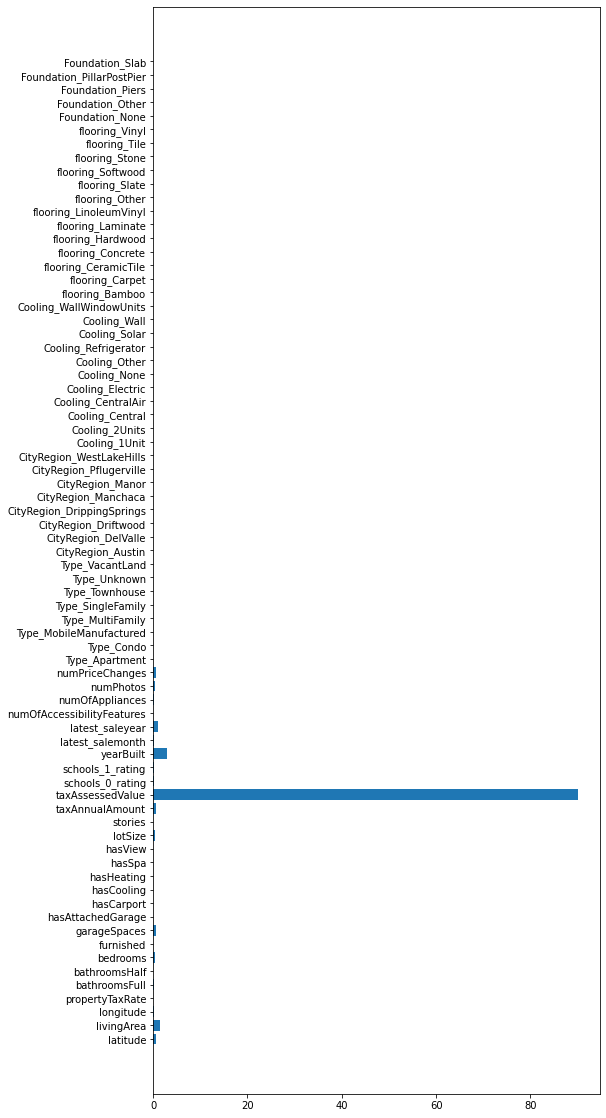

In [ ]:
plt.figure(figsize=(8,20))
plt.barh(X_train.columns, 100*dtr.feature_importances_)
plt.show()

## CART - Decision Tree Regressor with GridSearchCV

In [ ]:
grid_values = {'ccp_alpha': np.linspace(0, 0.10, 201),
               'min_samples_leaf': [5],
               'min_samples_split': [20],
               'max_depth': [30],
               'random_state': [88]}

dtr2 = DecisionTreeRegressor() # named dtr2 to not conflict with dtr
dtr_cv = GridSearchCV(dtr, param_grid=grid_values, cv=10, scoring='r2', 
                      verbose=2)
# Note: here we set verbose=2 to keep track of the progress (the running time) 
# of the cross validation.
dtr_cv.fit(X_train, y_train)

Fitting 10 folds for each of 201 candidates, totalling 2010 fits
[CV] END ccp_alpha=0.0, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.2s
[CV] END ccp_alpha=0.0, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.2s
[CV] END ccp_alpha=0.0, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.2s
[CV] END ccp_alpha=0.0, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.2s
[CV] END ccp_alpha=0.0, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.1s
[CV] END ccp_alpha=0.0, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.2s
[CV] END ccp_alpha=0.0, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.2s
[CV] END ccp_alpha=0.0, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.2s
[CV] EN

GridSearchCV(cv=10,
             estimator=DecisionTreeRegressor(ccp_alpha=0.02,
                                             min_samples_split=10,
                                             random_state=88),
             param_grid={'ccp_alpha': array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035,
       0.004 , 0.0045, 0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075,
       0.008 , 0.0085, 0.009 , 0.0095, 0.01  , 0.0105, 0.011 , 0.0115,
       0.012 , 0.0125, 0.013 , 0.0135, 0.014 , 0.0145, 0.015 , 0.0155,
       0.016 , 0.016...
       0.08  , 0.0805, 0.081 , 0.0815, 0.082 , 0.0825, 0.083 , 0.0835,
       0.084 , 0.0845, 0.085 , 0.0855, 0.086 , 0.0865, 0.087 , 0.0875,
       0.088 , 0.0885, 0.089 , 0.0895, 0.09  , 0.0905, 0.091 , 0.0915,
       0.092 , 0.0925, 0.093 , 0.0935, 0.094 , 0.0945, 0.095 , 0.0955,
       0.096 , 0.0965, 0.097 , 0.0975, 0.098 , 0.0985, 0.099 , 0.0995,
       0.1   ]),
                         'max_depth': [30], 'min_samples_leaf': [5],
  

### Hyperparameter Tuning

In [ ]:
# print(dtr_cv.best_params_['ccp_alpha'])

r2 = dtr_cv.cv_results_['mean_test_score']
ccp = dtr_cv.cv_results_['param_ccp_alpha'].data
pd.DataFrame({'ccp alpha' : ccp, 'R2': r2}).head()

,ccp alpha,R2
0,0,0.83108
1,0.0005,0.83108
2,0.001,0.83108
3,0.0015,0.83108
4,0.002,0.83108


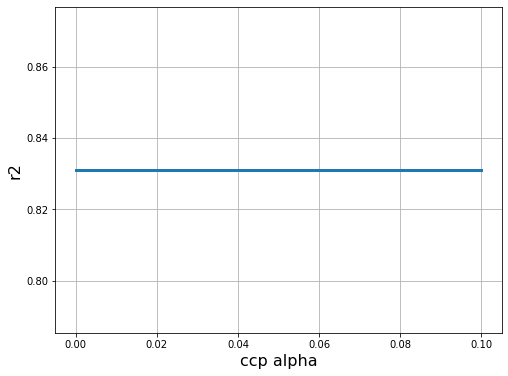

In [ ]:
plt.figure(figsize=(8, 6))
plt.xlabel('ccp alpha', fontsize=16)
plt.ylabel('r2', fontsize=16)
plt.scatter(ccp, r2, s=2)
plt.plot(ccp, r2, linewidth=3)
plt.grid(True, which='both')
plt.show()

In [ ]:
print('Grid best parameter ccp_alpha (max. r2): ', 
      dtr_cv.best_params_['ccp_alpha'])
print('Grid best score (r2): ', dtr_cv.best_score_)

Grid best parameter ccp_alpha (max. r2):  0.0
Grid best score (r2):  0.8310799462553323


Node count = 1629


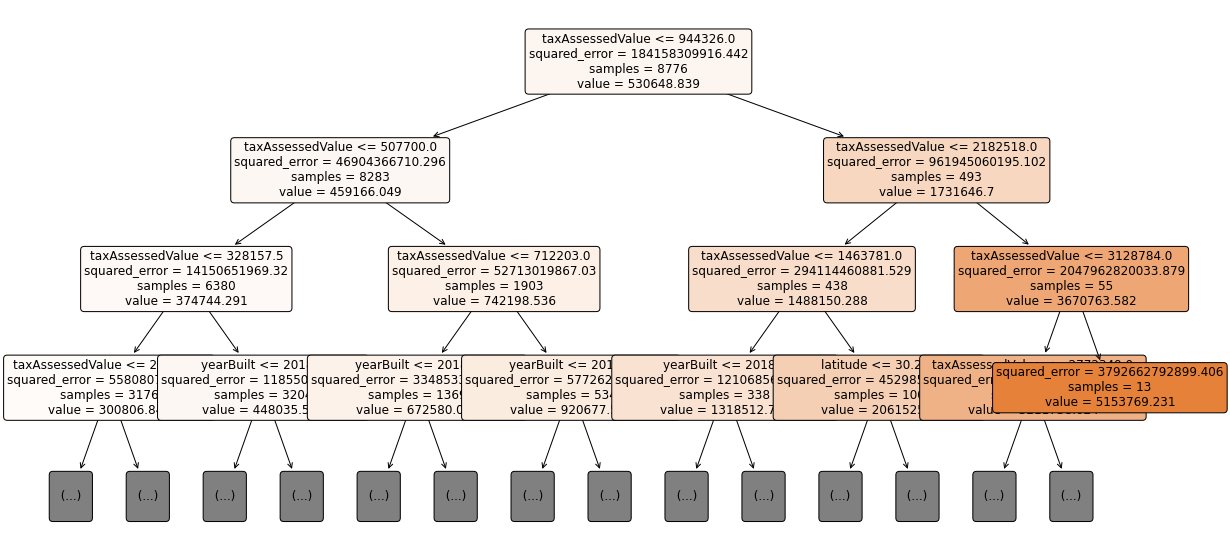

In [ ]:
print('Node count =', dtr_cv.best_estimator_.tree_.node_count)

plt.figure(figsize=(20,10))
plot_tree(dtr_cv.best_estimator_,
    feature_names=X_train.columns,
    class_names=['0','1'],
    filled=True,
    impurity=True,
    rounded=True,
    fontsize=12,
    max_depth=3)
plt.show()

### Model Performance

In [ ]:
# Only run this once after completing run for each model, because it will add a 
# row to the performance_table after every run
do_report_metrics_sklearn('Decision Tree Regressor (CV)', dtr_cv, X_test, y_test, y_train)

OSR2: 0.8364244548060847
RMSE: 191449.63357801113
MAE:  70813.18339505066


### Feature Importance

In [ ]:
pd.DataFrame({'Feature' : X_train.columns, 
              'Importance score': 100*dtr_cv.best_estimator_
                                            .feature_importances_}).round(1)

,Feature,Importance score
0,latitude,0.6
1,livingArea,0.5
2,longitude,0.1
3,propertyTaxRate,0.0
4,bathroomsFull,0.1
...,...,...
69,Foundation_None,0.0
70,Foundation_Other,0.0
71,Foundation_Piers,0.0
72,Foundation_PillarPostPier,0.0


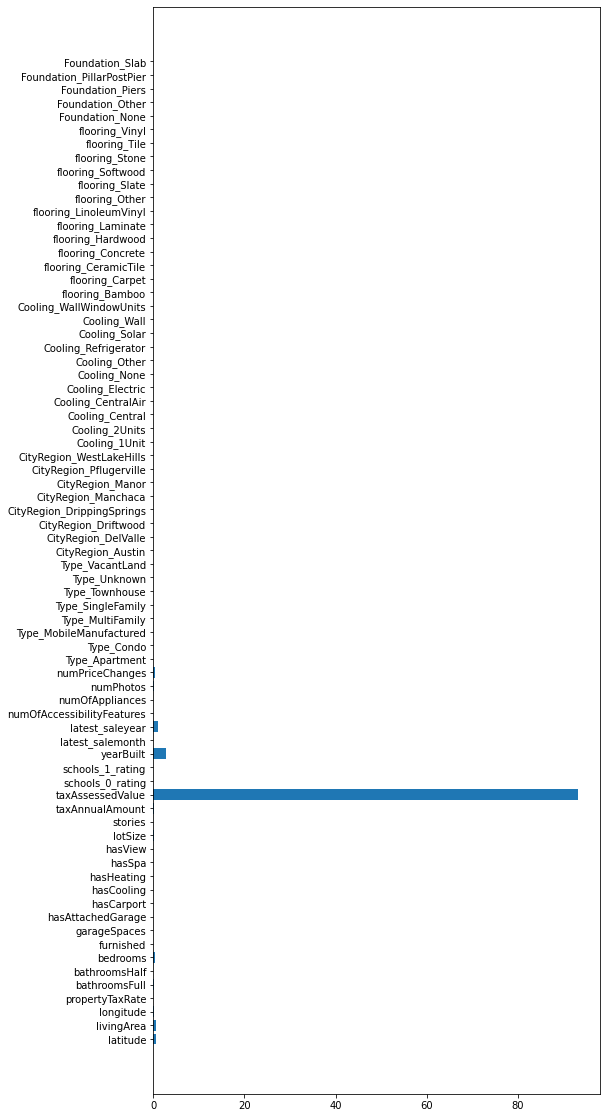

In [ ]:
plt.figure(figsize=(8,20))
plt.barh(X_train.columns, 100*dtr_cv.best_estimator_.feature_importances_)
plt.show()

## CART - Decision Tree Regressor with `np.log()` on target (`latest_price`)

In [ ]:
dtr3 = DecisionTreeRegressor(min_samples_split=10, ccp_alpha=0.02, 
                             random_state = 88)
dtr3 = dtr.fit(X_train, y_log_train) 

### Model Performance

In [ ]:
# Only run this once after completing run for each model, because it will add a 
# row to the performance_table after every run
do_report_metrics_sklearn('Decision Tree Regressor 3 (non-normalized)', 
                          dtr3, X_test, y_log_test, y_log_train)

OSR2: 0.7351523353604568
RMSE: 0.2706553600296121
MAE:  0.17924749538302798


In [ ]:
# Only run this once after completing run for each model, because it will add a 
# row to the performance_table after every run
do_report_metrics_sklearn('Decision Tree Regressor 3 (normalized)', 
                          dtr3, X_test, y_log_test, y_log_train, 
                          is_log_target = True)

OSR2: 0.5005547210931915
RMSE: 334533.26357347815
MAE:  112647.64763353951


In [ ]:
dtr3.score(X_test,np.log(y_test))

0.7351295296174049

## Random Forest Regressor Model

In [ ]:
# RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=74, min_samples_leaf=5, 
                           n_estimators = 500, random_state=42, verbose=2)
# Note: you can change the verbose parameter to control how much training 
# progress is printed.
rf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
b

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   40.9s finished


RandomForestRegressor(max_features=74, min_samples_leaf=5, n_estimators=500,
                      random_state=42, verbose=2)

### Model Performance

In [ ]:
# Only run this once after completing run for each model, because it will add a 
# row to the performance_table after every run
do_report_metrics_sklearn('Random Forest Regressor', rf, X_test, y_test, 
                          y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


OSR2: 0.8465112078623567
RMSE: 185452.92413760728
MAE:  59595.0269789157


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.5s finished


### Feature Importance

In [ ]:
pd.DataFrame({'Feature' : X_train.columns, 
              'Importance score': 100*rf.feature_importances_}).round(1)

,Feature,Importance score
0,latitude,0.6
1,livingArea,1.1
2,longitude,0.4
3,propertyTaxRate,0.0
4,bathroomsFull,0.2
...,...,...
69,Foundation_None,0.0
70,Foundation_Other,0.0
71,Foundation_Piers,0.0
72,Foundation_PillarPostPier,0.0


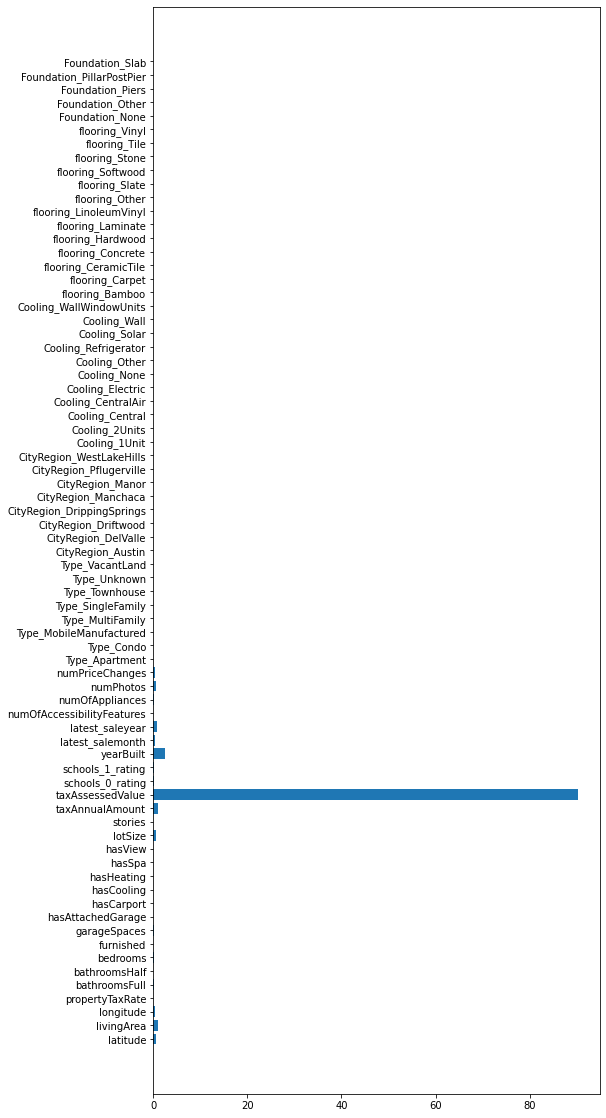

In [ ]:
plt.figure(figsize=(8,20))
plt.barh(X_train.columns, 100*rf.feature_importances_)
plt.show()

## Random Forest Regressor with GridSearchCV

Define the grid values and perform the Grid Search Cross-Validation

In [ ]:
## using GridSearchCV to find best max_features:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import time

grid_values = {'max_features': np.linspace(1,18,18, dtype='int32'),
               'min_samples_leaf': [5],
               'n_estimators': [500],
               'random_state': [42]} 

tic = time.time()

rf2 = RandomForestRegressor() # named rf2 to not conflict with rf
# Note: here we set verbose=2 to keep track of the progress (the running time) 
# of the cross validation. 
cv = KFold(n_splits=5,random_state=333,shuffle=True) 
rf_cv = GridSearchCV(rf2, param_grid=grid_values, scoring='r2', cv=cv,verbose=2)
rf_cv.fit(X_train, y_train)

toc = time.time()

print('time:', round(toc-tic, 2),'s')

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=42; total time=   1.1s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=42; total time=   1.1s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=42; total time=   1.1s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=42; total time=   1.1s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=42; total time=   1.1s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=42; total time=   1.5s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=42; total time=   1.5s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=42; total time=   1.6s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=42; total time=   1.5s
[CV] END max_features=2, min_samples_leaf=5, n_e

### Hyperparameter Tuning

In [ ]:
print(rf_cv.best_params_)

{'max_features': 18, 'min_samples_leaf': 5, 'n_estimators': 500, 'random_state': 42}


In [ ]:
print('Grid best score (r2): ', rf_cv.best_score_)

Grid best score (r2):  0.8560019210848491


Let's try `max_features: np.linspace(1,37,37, dtype='int32')`

In [ ]:
## using GridSearchCV to find best max_features:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import time

grid_values = {'max_features': np.linspace(1,37,37, dtype='int32'),
               'min_samples_leaf': [5],
               'n_estimators': [500],
               'random_state': [42]} 

tic = time.time()

rf2b = RandomForestRegressor() # named rf2 to not conflict with rf
# Note: here we set verbose=2 to keep track of the progress (the running time) 
# of the cross validation. 
cv = KFold(n_splits=5,random_state=333,shuffle=True) 
rf_cv2b = GridSearchCV(rf2b, param_grid=grid_values, scoring='r2', cv=cv,verbose=2)
rf_cv2b.fit(X_train, y_train)

toc = time.time()

print('time:', round(toc-tic, 2),'s')

Fitting 5 folds for each of 37 candidates, totalling 185 fits
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=42; total time=   1.1s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=42; total time=   1.1s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=42; total time=   1.1s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=42; total time=   1.1s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=42; total time=   1.1s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=42; total time=   1.5s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=42; total time=   1.5s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=42; total time=   1.5s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=42; total time=   1.5s
[CV] END max_features=2, min_samples_leaf=5, n_

In [ ]:
print(rf_cv2b.best_params_)

{'max_features': 37, 'min_samples_leaf': 5, 'n_estimators': 500, 'random_state': 42}


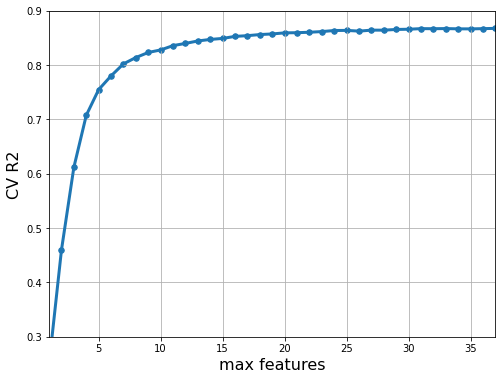

In [ ]:
max_features = rf_cv2b.cv_results_['param_max_features'].data
R2_scores = rf_cv2b.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.xlabel('max features', fontsize=16)
plt.ylabel('CV R2', fontsize=16)
plt.scatter(max_features, R2_scores, s=30)
plt.plot(max_features, R2_scores, linewidth=3)
plt.grid(True, which='both')
plt.xlim([1, 37])
plt.ylim([0.3, 0.9])
plt.show()

In [ ]:
print('Grid best score (r2): ', rf_cv2b.best_score_)

Grid best score (r2):  0.8673765308226308


Now, let's try `'max_features': np.linspace(4,74,8, dtype='int32')`

In [ ]:
## using GridSearchCV to find best max_features:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import time

grid_values1 = {'max_features': np.linspace(4,74,8, dtype='int32'),
               'min_samples_leaf': [5],
               'n_estimators': [500],
               'random_state': [42]} 

tic1 = time.time()

rf2c = RandomForestRegressor() # named rf2 to not conflict with rf
# Note: here we set verbose=2 to keep track of the progress (the running time) 
# of the cross validation. 
cv = KFold(n_splits=5,random_state=333,shuffle=True) 
rf_cv2c = GridSearchCV(rf2c, param_grid=grid_values1, scoring='r2', cv=cv,verbose=2)
rf_cv2c.fit(X_train, y_train)

toc1 = time.time()

print('time:', round(toc1-tic1, 2),'s')

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END max_features=4, min_samples_leaf=5, n_estimators=500, random_state=42; total time=   3.0s
[CV] END max_features=4, min_samples_leaf=5, n_estimators=500, random_state=42; total time=   2.9s
[CV] END max_features=4, min_samples_leaf=5, n_estimators=500, random_state=42; total time=   3.0s
[CV] END max_features=4, min_samples_leaf=5, n_estimators=500, random_state=42; total time=   3.0s
[CV] END max_features=4, min_samples_leaf=5, n_estimators=500, random_state=42; total time=   3.0s
[CV] END max_features=14, min_samples_leaf=5, n_estimators=500, random_state=42; total time=   7.9s
[CV] END max_features=14, min_samples_leaf=5, n_estimators=500, random_state=42; total time=   7.9s
[CV] END max_features=14, min_samples_leaf=5, n_estimators=500, random_state=42; total time=  15.3s
[CV] END max_features=14, min_samples_leaf=5, n_estimators=500, random_state=42; total time=  12.3s
[CV] END max_features=14, min_samples_leaf=5,

In [ ]:
print(rf_cv2c.best_params_)

{'max_features': 44, 'min_samples_leaf': 5, 'n_estimators': 500, 'random_state': 42}


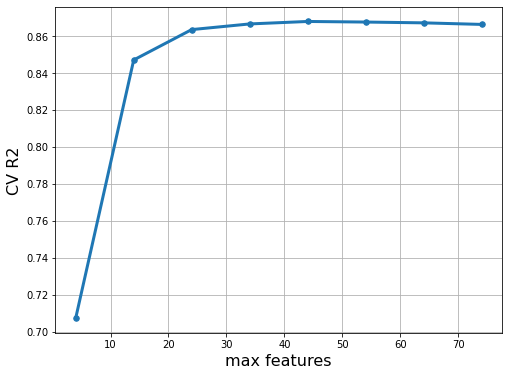

In [ ]:
max_features = rf_cv2c.cv_results_['param_max_features'].data
R2_scores = rf_cv2c.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.xlabel('max features', fontsize=16)
plt.ylabel('CV R2', fontsize=16)
plt.scatter(max_features, R2_scores, s=30)
plt.plot(max_features, R2_scores, linewidth=3)
plt.grid(True, which='both')
plt.show()

From this graph, we can see using `max_features` set to 44 will give us the highest CV R2. Beyond that number, the CV R2 levels off or even dips down.

In [ ]:
print('Grid best score (r2): ', rf_cv2c.best_score_)

Grid best score (r2):  0.8678407443390406


### Model performance

In [ ]:
# Only run this once after completing run for each model, because it will add a 
# row to the performance_table after every run
do_report_metrics_sklearn('Random Forest Regressor (CV)', rf_cv2c, X_test, 
                          y_test, y_train)

OSR2: 0.8334416514369011
RMSE: 193187.29177365516
MAE:  60168.79467904371


### Feature Importance

In [ ]:
pd.DataFrame({'Feature' : X_train.columns,  
              'Importance score': 100*rf_cv2c.best_estimator_
                                             .feature_importances_}).round(1)

,Feature,Importance score
0,latitude,0.7000000
1,livingArea,5.9000000
2,longitude,0.6000000
3,propertyTaxRate,0.0000000
4,bathroomsFull,2.0000000
...,...,...
69,Foundation_None,0.0000000
70,Foundation_Other,0.0000000
71,Foundation_Piers,0.1000000
72,Foundation_PillarPostPier,0.0000000


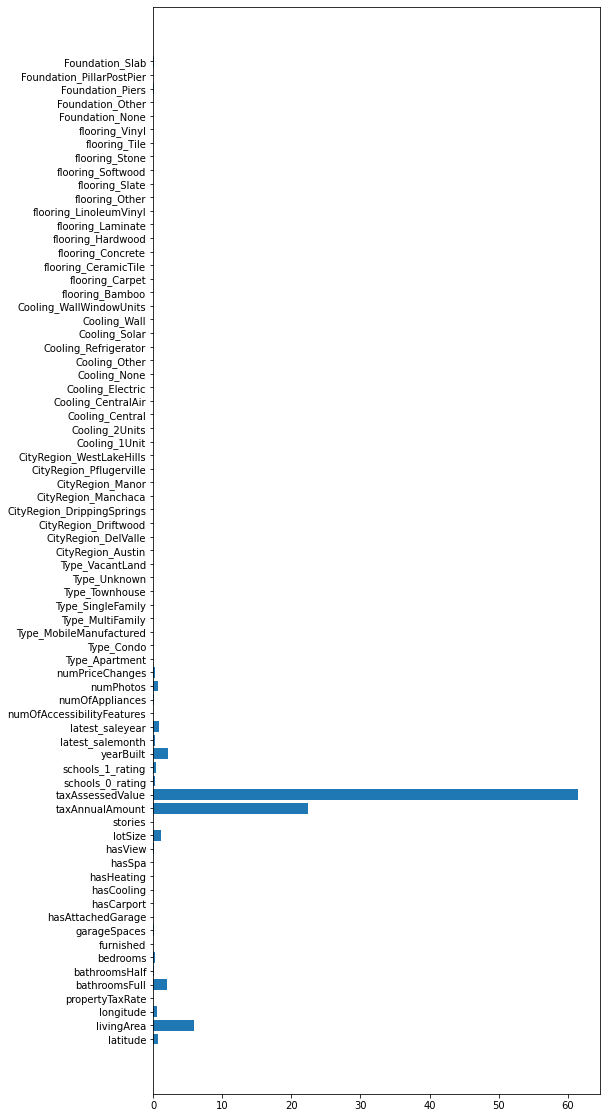

In [ ]:
plt.figure(figsize=(8,20))
plt.barh(X_train.columns, 100*rf_cv2c.best_estimator_.feature_importances_)
plt.show()

## Random Forest Regressor Model with np.log on target (latest_price)

In [ ]:
# RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

rf3 = RandomForestRegressor(max_features=5, min_samples_leaf=5, 
                           n_estimators = 500, random_state=42, verbose=2)
# Note: you can change the verbose parameter to control how much training 
# progress is printed.
rf3.fit(X_train, y_log_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
b

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.4s finished


RandomForestRegressor(max_features=5, min_samples_leaf=5, n_estimators=500,
                      random_state=42, verbose=2)

### Model Performance

In [ ]:
# Only run this once after completing run for each model, because it will add a 
# row to the performance_table after every run
do_report_metrics_sklearn('Random Forest Regressor 3 (non-normalized)', rf3, 
                          X_test, y_log_test, y_log_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


OSR2: 0.8095698530306019
RMSE: 0.2295019656907239
MAE:  0.1367064941669752


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


In [ ]:
# Only run this once after completing run for each model, because it will add a 
# row to the performance_table after every run
do_report_metrics_sklearn('Random Forest Regressor 3 (normalized)', rf3, X_test, 
                          y_log_test, y_log_train, is_log_target = True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


OSR2: 0.5367777479683549
RMSE: 322173.68017887056
MAE:  93144.87266295738


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


## Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(learning_rate=0.1775,random_state= 45, 
                                verbose=2) 
# gbr originally named boost
gbr.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1 134804545301.7814            4.17s
         2 100329685807.3447            3.70s
         3 76695193554.2774            3.70s
         4 59946095427.4473            3.62s
         5 48257118621.2144            3.49s
         6 39884553707.9943            3.42s
         7 33986509993.5559            3.34s
         8 29869807959.9390            3.29s
         9 26550066895.1109            3.28s
        10 24074324974.2050            3.25s
        11 22070567364.1083            3.19s
        12 20725421783.7354            3.16s
        13 19420934090.4187            3.10s
        14 18445942659.0297            3.08s
        15 17770318012.3209            3.03s
        16 17124776953.5168            2.99s
        17 16389904175.0281            2.94s
        18 15754884047.0639            2.91s
        19 15160040150.5725            2.90s
        20 14713490386.2356            2.85s
        21 14407191199.1564            2.81s
       

GradientBoostingRegressor(learning_rate=0.1775, random_state=45, verbose=2)

### Model Performance

In [ ]:
# Only run this once after completing run for each model, because it will add a 
# row to the performance_table after every run
do_report_metrics_sklearn('Gradient Boosting Regressor', gbr, X_test, y_test, 
                          y_train)

OSR2: 0.8410561290176668
RMSE: 188719.70288411857
MAE:  61951.78001597333


### Feature Importance

In [ ]:
pd.DataFrame({'Feature' : X_train.columns, 
              'Importance score': 100*gbr.feature_importances_}).round(1)

,Feature,Importance score
0,latitude,0.2
1,livingArea,2.1
2,longitude,0.4
3,propertyTaxRate,0.0
4,bathroomsFull,0.4
...,...,...
69,Foundation_None,0.0
70,Foundation_Other,0.0
71,Foundation_Piers,0.0
72,Foundation_PillarPostPier,0.0


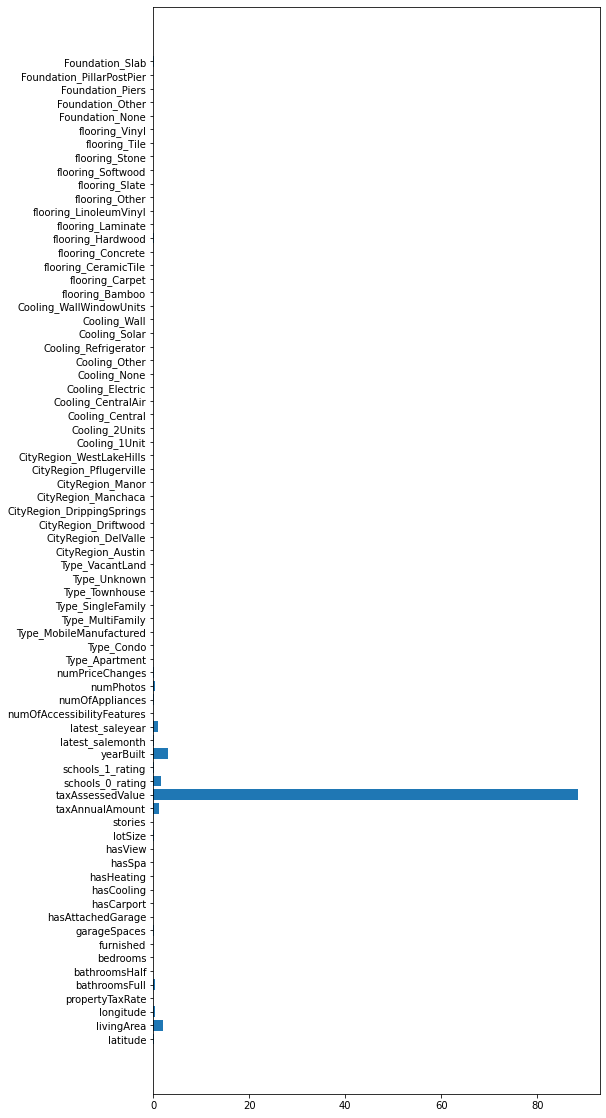

In [ ]:
plt.figure(figsize=(8,20))
plt.barh(X_train.columns, 100*gbr.feature_importances_)
plt.show()

## Gradient Boosting Regressor with GridSearchCV 

In [ ]:
grid={'learning_rate':np.linspace(.055,.3,5),
      'n_estimators':range(100,501,100),
      'random_state':[45]
     }

gbr2=GradientBoostingRegressor() # originally named estimator
# named gbr2 to not conflict with gbr

gbr_cv=GridSearchCV(gbr2,grid,cv=5,verbose=2).fit(X_train,y_train) 
# originally named cv_search

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END learning_rate=0.055, n_estimators=100, random_state=45; total time=   2.6s
[CV] END learning_rate=0.055, n_estimators=100, random_state=45; total time=   2.5s
[CV] END learning_rate=0.055, n_estimators=100, random_state=45; total time=   2.6s
[CV] END learning_rate=0.055, n_estimators=100, random_state=45; total time=   2.5s
[CV] END learning_rate=0.055, n_estimators=100, random_state=45; total time=   2.5s
[CV] END learning_rate=0.055, n_estimators=200, random_state=45; total time=   5.0s
[CV] END learning_rate=0.055, n_estimators=200, random_state=45; total time=   5.0s
[CV] END learning_rate=0.055, n_estimators=200, random_state=45; total time=   5.0s
[CV] END learning_rate=0.055, n_estimators=200, random_state=45; total time=   5.0s
[CV] END learning_rate=0.055, n_estimators=200, random_state=45; total time=   5.0s
[CV] END learning_rate=0.055, n_estimators=300, random_state=45; total time=   7.6s
[CV] END learn

### Hyperparameter Tuning

In [ ]:
gbr_cv.best_params_

{'learning_rate': 0.23875, 'n_estimators': 100, 'random_state': 45}

### Model Performance

In [ ]:
# Only run this once after completing run for each model, because it will add a 
# row to the performance_table after every run
do_report_metrics_sklearn('Gradient Boosting Regressor (CV)', gbr_cv, X_test, 
                          y_test, y_train)

OSR2: 0.8467531299040539
RMSE: 185306.71527776736
MAE:  61981.94475128085


### Feature Performance

In [ ]:
pd.DataFrame({'Feature' : X_train.columns,  
              'Importance score': 100*gbr_cv.best_estimator_
                                            .feature_importances_}).round(1)

,Feature,Importance score
0,latitude,0.3000000
1,livingArea,2.0000000
2,longitude,0.6000000
3,propertyTaxRate,0.0000000
4,bathroomsFull,0.5000000
...,...,...
69,Foundation_None,0.0000000
70,Foundation_Other,0.0000000
71,Foundation_Piers,0.0000000
72,Foundation_PillarPostPier,0.0000000


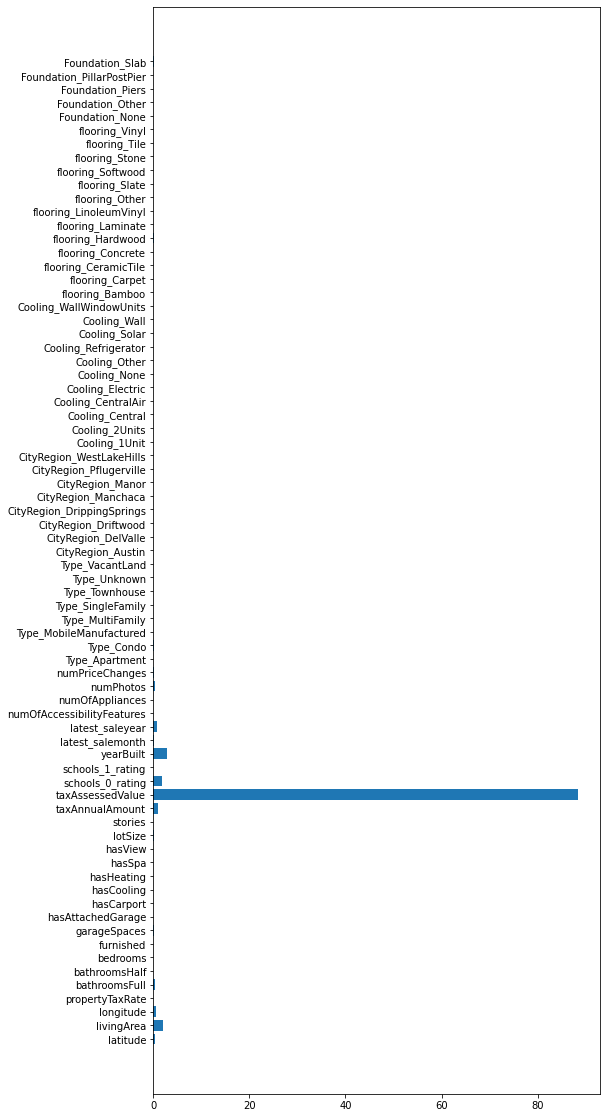

In [ ]:
plt.figure(figsize=(8,20))
plt.barh(X_train.columns, 100*gbr_cv.best_estimator_.feature_importances_)
plt.show()

## Gradient Boosting Regressor with `np.log()` on target (`latest_price`)

In [ ]:
important=(pd.Series(gbr.feature_importances_,index=X_train.columns)
                    .sort_values(ascending=False))
important.head(10)

taxAssessedValue   0.8853883
yearBuilt          0.0312919
livingArea         0.0208016
schools_0_rating   0.0166162
taxAnnualAmount    0.0113885
latest_saleyear    0.0101271
bathroomsFull      0.0040338
longitude          0.0038635
numPhotos          0.0029587
latitude           0.0023639
dtype: float64

In [ ]:
X2_train=X_train[important.head(10).index]
X2_test=X_test[important.head(10).index]

In [ ]:
grid={'learning_rate':np.linspace(.001,.2,10),
      'n_estimators':range(100,501,100),
      'max_depth':range(1,4),
      'random_state':[45]
     }

gbr3=GradientBoostingRegressor()

gbr_cv3=GridSearchCV(gbr3,grid,cv=5,verbose=2).fit(X2_train,y_log_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
[CV] END learning_rate=0.001, max_depth=1, n_estimators=100, random_state=45; total time=   0.6s
[CV] END learning_rate=0.001, max_depth=1, n_estimators=100, random_state=45; total time=   0.6s
[CV] END learning_rate=0.001, max_depth=1, n_estimators=100, random_state=45; total time=   0.6s
[CV] END learning_rate=0.001, max_depth=1, n_estimators=100, random_state=45; total time=   0.6s
[CV] END learning_rate=0.001, max_depth=1, n_estimators=100, random_state=45; total time=   0.6s
[CV] END learning_rate=0.001, max_depth=1, n_estimators=200, random_state=45; total time=   1.2s
[CV] END learning_rate=0.001, max_depth=1, n_estimators=200, random_state=45; total time=   1.2s
[CV] END learning_rate=0.001, max_depth=1, n_estimators=200, random_state=45; total time=   1.2s
[CV] END learning_rate=0.001, max_depth=1, n_estimators=200, random_state=45; total time=   1.2s
[CV] END learning_rate=0.001, max_depth=1, n_estimators=200, ran

In [ ]:
gbr_cv3.best_params_

{'learning_rate': 0.06733333333333334,
 'max_depth': 2,
 'n_estimators': 300,
 'random_state': 45}

In [ ]:
gbr_model3=GradientBoostingRegressor(learning_rate=0.06733333333333334,
                                     max_depth=2,n_estimators=300,
                                     random_state=45).fit(X2_train,y_log_train)

In [ ]:
gbr_model3.score(X2_test,y_log_test)

0.8771078928475942

### Model Performance

In [ ]:
# Only run this once after completing run for each model, because it will add a 
# row to the performance_table after every run
do_report_metrics_sklearn('Gradient Boosting Regressor 3 (non-normalized)', 
                          gbr_model3, X2_test, y_log_test, y_log_train)

OSR2: 0.8771184740415445
RMSE: 0.18435794405479816
MAE:  0.09770565459636119


In [ ]:
# Only run this once after completing run for each model, because it will add a 
# row to the performance_table after every run
do_report_metrics_sklearn('Gradient Boosting Regressor 3 (normalized)', 
                          gbr_model3, X2_test, y_log_test, y_log_train, 
                          is_log_target = True)

OSR2: 0.8169803304958695
RMSE: 202508.95594711462
MAE:  62112.795082823


### Feature Importance

In [ ]:
pd.DataFrame({'Feature' : X2_train.columns,  
              'Importance score': 100*gbr_model3.feature_importances_}).round(1)

,Feature,Importance score
0,taxAssessedValue,92.3
1,yearBuilt,2.7
2,livingArea,0.9
3,schools_0_rating,0.0
4,taxAnnualAmount,0.6
5,latest_saleyear,1.7
6,bathroomsFull,0.6
7,longitude,0.4
8,numPhotos,0.4
9,latitude,0.5


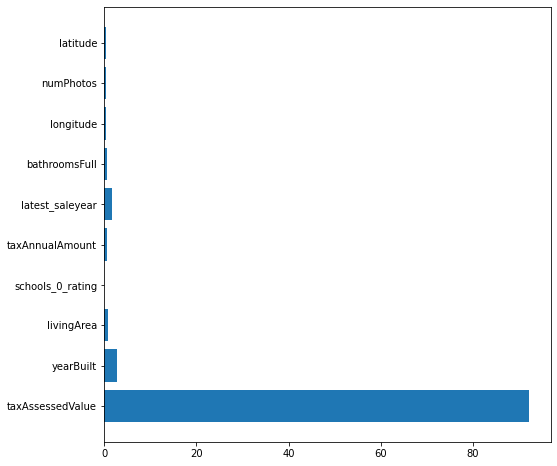

In [ ]:
plt.figure(figsize=(8,8))
plt.barh(X2_train.columns, 100*gbr_model3.feature_importances_)
plt.show()

## Comparison of Model Performance Metrics

### Overall Model Performance Table

Now that I have produced the models and calculated the metrics, let's see the comparison of the model performance metrics in the `performance_table` below.

In [ ]:
performance_table

,Algorithm,OSR^2,RMSE,MAE
0,Linear Regression (OLS),0.7686046,227705.0606961,77046.6189840
1,Decision Tree Regressor,0.8209755,200286.4857641,80723.5430935
2,Decision Tree Regressor (CV),0.8364245,191449.6335780,70813.1833951
3,Decision Tree Regressor 3 (non-normalized),0.7351523,0.2706554,0.1792475
4,Decision Tree Regressor 3 (normalized),0.5005547,334533.2635735,112647.6476335
5,Random Forest Regressor,0.8465112,185452.9241376,59595.0269789
6,Random Forest Regressor (CV),0.8334417,193187.2917737,60168.7946790
7,Random Forest Regressor 3 (non-normalized),0.8095699,0.2295020,0.1367065
8,Random Forest Regressor 3 (normalized),0.5367777,322173.6801789,93144.8726630
9,Gradient Boosting Regressor,0.8410561,188719.7028841,61951.7800160


It looks like the models using `np.log()` on the target `latest_price` (which are denoted with number 3) perform worse than without. Let's display the table without those models.

In [ ]:
(performance_table
  [~performance_table.Algorithm.str.contains('3')]
  .reset_index(drop=True)
)

,Algorithm,OSR^2,RMSE,MAE
0,Linear Regression (OLS),0.7686046,227705.0606961,77046.6189840
1,Decision Tree Regressor,0.8209755,200286.4857641,80723.5430935
2,Decision Tree Regressor (CV),0.8364245,191449.6335780,70813.1833951
3,Random Forest Regressor,0.8465112,185452.9241376,59595.0269789
4,Random Forest Regressor (CV),0.8334417,193187.2917737,60168.7946790
5,Gradient Boosting Regressor,0.8410561,188719.7028841,61951.7800160
6,Gradient Boosting Regressor (CV),0.8467531,185306.7152778,61981.9447513


From the table above, it looks like Gradient Boosting Regressor with GridSearchCV model performs the best with $\mathrm{OSR}^2 = 0.846753$. The RMSE and MAE are comparable to other models. Now, let's use bootstrap on this model to assess its performance.

## Bootstrapping

`bootstrap_validation()` is adapted from Lab 8b with code to handle LabelEncoded target values, When the data is passed into `bootstrap_validation()`, they can be in 2 possible forms:

- both target test data and feature test data are in raw form with indices
- Label encoded target values lose their indices during encoding while feature test data still have old indicies To handle the second case, code is added to `bootstrap_validation()` to strip all the old indices and simply re-index it with sequential numbers.

In [ ]:
import time

def bootstrap_validation(test_data, test_label, train_label, model, 
                         metrics_list, sample=500, random_state=66):
    if type(test_label) == np.ndarray:
        test_data = test_data.copy().reset_index().drop(['index'],axis=1)

    tic = time.time()
    n_sample = sample
    n_metrics = len(metrics_list)
    output_array=np.zeros([n_sample, n_metrics])
    output_array[:]=np.nan
    print(output_array.shape)
    for bs_iter in range(n_sample):
        bs_index = np.random.choice(test_data.index, len(test_data.index), replace=True)
        bs_data = test_data.loc[bs_index]
        if type(test_label) == np.ndarray:
            bs_label = test_label[bs_index]
        else:
            bs_label = test_label.loc[bs_index]
        bs_predicted = model.predict(bs_data)
        for metrics_iter in range(n_metrics):
            metrics = metrics_list[metrics_iter]
            output_array[bs_iter, metrics_iter]=metrics(bs_predicted,bs_label,train_label)
#         if bs_iter % 100 == 0:
#             print(bs_iter, time.time()-tic)
    output_df = pd.DataFrame(output_array)
    return output_df

The function `show_bootstrap()` below will perform the following 2 tasks:
- Compute and report the metrics
- Plot histogram results of the bootstrap

In [ ]:
def show_bootstrap_results(bs_output):
    # Compute and report the metrics
    df = pd.DataFrame({
        'Mean': [np.mean(bs_output.iloc[:,0]),
                 np.mean(bs_output.iloc[:,1]),
                 np.mean(bs_output.iloc[:,2])],
        'Standard Deviation': [np.std(bs_output.iloc[:,0]),
                               np.std(bs_output.iloc[:,1]),
                               np.std(bs_output.iloc[:,2])]    
    },index = ['OSR^2', 'RMSE', 'MAE'])
    pd.set_option('display.float_format', lambda x: '%.7f' % x)
    display(df)
    # Plot histogram results of the bootstrap
    fig, axs = plt.subplots(ncols=3,nrows=1, figsize=(16,5))

    axs[0].set_xlabel('OSR^2', fontsize=16)
    axs[1].set_xlabel('RMSE', fontsize=16)
    axs[2].set_xlabel('MAE', fontsize=16)
    axs[0].hist(bs_output.iloc[:,0], bins=20,edgecolor='green', linewidth=2,color = "grey")
    axs[1].hist(bs_output.iloc[:,1], bins=20,edgecolor='green', linewidth=2,color = "grey")
    axs[2].hist(bs_output.iloc[:,2], bins=20,edgecolor='green', linewidth=2,color = "grey")
    #axs[1].set_xlim([-0.15,0.15])
    plt.show()
    return 

In [ ]:
bs_output = bootstrap_validation(X_test, y_test, y_train, gbr_cv, 
                                 metrics_list=[OS_R_squared,mean_squared_error,
                                              mean_absolute_error], sample=5000)
bs_output

(5000, 3)


,0,1,2
0,0.854967,2.571706e+10,59881.117644
1,0.848878,4.025519e+10,66593.160358
2,0.870684,3.368127e+10,64416.128143
3,0.870050,3.238825e+10,65930.118953
4,0.826949,4.311431e+10,66591.724316
...,...,...,...
4995,0.882280,1.907777e+10,60833.447459
4996,0.788548,6.251542e+10,70246.307119
4997,0.864129,2.277783e+10,55756.833425
4998,0.787868,5.544051e+10,63947.933579


,Mean,Standard Deviation
OSR^2,0.8494749,0.0293156
RMSE,34262879730.9340057,11040360967.6643448
MAE,61950.3420242,2800.3430938


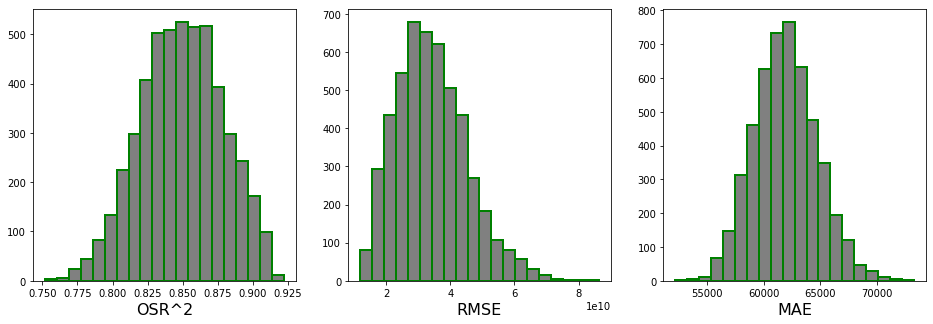

In [ ]:
show_bootstrap_results(bs_output)

### Confidence Interval

Below, let's also take a look at its confidence interval.

#### Basic plot and centered plot

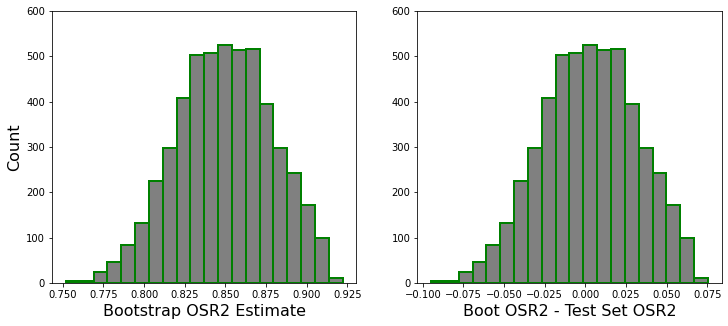

In [ ]:
y_pred = gbr_cv.predict(X_test)
test_OSR2 = OS_R_squared(y_pred,y_test,y_train)

fig, axs = plt.subplots(ncols=2, figsize=(12,5))
axs[0].set_xlabel('Bootstrap OSR2 Estimate', fontsize=16)
axs[1].set_xlabel('Boot OSR2 - Test Set OSR2', fontsize=16)
axs[0].set_ylabel('Count', fontsize=16)
axs[0].hist(bs_output.iloc[:,0], bins=20,edgecolor='green', 
            linewidth=2,color = "grey")
#axs[0].set_xlim([0.4,0.7])
axs[1].hist(bs_output.iloc[:,0]-test_OSR2, bins=20,edgecolor='green', 
            linewidth=2,color = "grey")
#axs[1].set_xlim([-0.15,0.15])
axs[0].set_ylim([0,600])
axs[1].set_ylim([0,600])
plt.show()

#### Basic Plot with Confidence Interval

In [ ]:
# The 95% confidence interval
CI_0 = np.quantile(bs_output.iloc[:,0],np.array([0.025,0.975]))
#CI[0] = test_OSR2 - CI_0[1]
#CI[1] = test_OSR2 - CI_0[0]
CI = [0, 0]
CI[0] = CI_0[0]
CI[1] = CI_0[1]
print("The 95-percent confidence interval of Bootstrap OSR2 is %s" % CI) 

The 95-percent confidence interval of Bootstrap OSR2 is [0.7911589956335608, 0.9044311274038622]


In [ ]:
# The 95% confidence interval
CI = [0, 1]
CI_0 = np.quantile(bs_output.iloc[:,0],np.array([0.025,0.975]))
CI[0] = test_OSR2 - CI_0[1]
CI[1] = test_OSR2 - CI_0[0]
#CI[0] = CI_0[0]
#CI[1] = CI_0[1]
print("The 95-percent confidence interval of OSR2 is %s" % CI) 

The 95-percent confidence interval of OSR2 is [-0.05767799749980829, 0.05559413427049309]


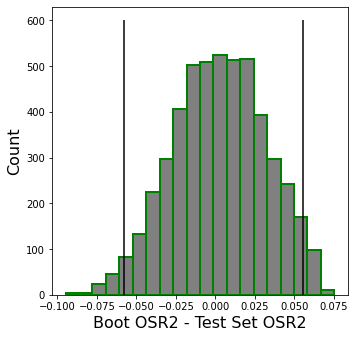

In [ ]:
fig, axs = plt.subplots(ncols=1, figsize=(5.3,5.3))
axs.set_xlabel('Boot OSR2 - Test Set OSR2', fontsize=16)
axs.set_ylabel('Count', fontsize=16)
#axs.hist(bs_output.iloc[:,0], bins=20,edgecolor='green', linewidth=2,color = "grey")
axs.hist(bs_output.iloc[:,0] - test_OSR2, bins=20,edgecolor='green', 
         linewidth=2,color = "grey")
##axs.set_xlim([-0.15,0.15])
axs.vlines(x=CI[0], ymin = 0, ymax =600, color = "black")
axs.vlines(x=CI[1], ymin = 0, ymax =600, color = "black")
plt.show()